In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon,nd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from multiprocessing import cpu_count
from gluonts.transform import (
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    )

In [2]:
# ctx = mx.cpu(cpu_count)
mx.random.seed(0)
np.random.seed(0)

In [3]:
file_name = "../data/dataset_v01.csv"
df = pd.read_csv(file_name)
df.head(5)

,Unnamed: 0,dt,caiso_load,eia_load,caiso_solar,eia_solar,caiso_wind,eia_wind,cat_hour,cat_day,cat_week,cat_month,cat_year,caiso_net_load,eia_net_load,caiso_ramp,eia_ramp
0,0,2018-07-01 01:00:00,25444.0,26061.0,-18.17598,0.0,3614.42703,3958.0,1,6,26,7,2018,21847.74895,22103.0,NaN,NaN
1,1,2018-07-01 02:00:00,24056.0,24604.0,-18.42822,0.0,3556.83377,4087.0,2,6,26,7,2018,20517.59445,20517.0,-1330.15450,-1586.0
2,2,2018-07-01 03:00:00,23064.0,23554.0,-19.48557,0.0,3392.16842,3710.0,3,6,26,7,2018,19691.31715,19844.0,-826.27730,-673.0
3,3,2018-07-01 04:00:00,22407.0,22843.0,-20.36934,0.0,3074.91935,3630.0,4,6,26,7,2018,19352.44999,19213.0,-338.86716,-631.0
4,4,2018-07-01 05:00:00,22130.0,22538.0,-6.01978,0.0,2633.41362,3156.0,5,6,26,7,2018,19502.60616,19382.0,150.15617,169.0


In [4]:
file_name = "../data/dataset_v01.csv"
file_name = "../data/EIA-20180701-20201109.csv"
# file_name = "../data/CAISO-20170701-20201030.csv"
df = pd.read_csv(file_name)
# df = pd.read_csv("../data/EIA-20180701-20201109.csv")
# df = pd.read_csv("../data/CAISO-20170701-20201030.csv")
# df['start_dt'] = df['start_dt'].apply(lambda x:pd.Timestamp(x)).dt.strftime('%Y-%m-%d %H')
# df = df.drop('Unnamed: 0',axis=1)
# df.index = df['dt']
# df.head()
df['dt'] = df['dt'].apply(lambda x:pd.Timestamp(x)).dt.tz_localize(None)
df['eia_ramp'] = (df['demand_MWh'] - df['wind_gen_MWh'] - df['solar_gen_MWh']).diff()
df.head(5)

,Unnamed: 0,dt,demand_MWh,wind_gen_MWh,solar_gen_MWh,eia_ramp
0,0,2018-07-01 08:00:00,26061,3958,0,NaN
1,1,2018-07-01 09:00:00,24604,4087,0,-1586.0
2,2,2018-07-01 10:00:00,23554,3710,0,-673.0
3,3,2018-07-01 11:00:00,22843,3630,0,-631.0
4,4,2018-07-01 12:00:00,22538,3156,0,169.0


In [5]:
#EIA or Merged
if 'CAI' not in file_name:
    print("In File",len(pd.date_range(start=df['dt'][0],end=df['dt'][len(df)-1],freq='H')),"Actual",len(df))
#CAISO
else:
    print("In FIle",len(pd.date_range(start="2017-07-01 07:00:00+00:00",end="2020-10-30 22:00:00+00:00",freq='H')),"Actual",len(df))

In File 20689 Actual 20689


In [6]:
total_data_size =  len(df)
total_data_size

20689

# Data Splitting
Total data is split into three parts 
1. 80% is train data
2. 10% is validation data
3. 10% is test data

In [7]:
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
test_size = total_data_size - (train_size + val_size)

print("Train size ",train_size, "Validation size ", val_size, "Test size ",test_size)

Train size  16551 Validation size  2068 Test size  2070


In [8]:
def create_dataset(df,num_series, num_steps, period=24, mu=1, sigma=0.3):
#     df =  pd.read_csv("../data/dataset_v01.csv")
    target = df['eia_ramp'].to_numpy().reshape(1,-1)
    #TODO: Consider normalizing features
#     feat_dynamic_cat = np.vstack((df.loc[:,"cat_hour"].to_numpy() , df.loc[:,'cat_day'].to_numpy(), df.loc[:,'cat_month'].to_numpy())).T
    return target#, feat_dynamic_cat.reshape(3,-1)
    return nd.array(target).copyto(mx.gpu(0)), nd.array(feat_dynamic_cat.reshape(3,-1)).copyto(mx.gpu(0))
    

In [9]:
custom_ds_metadata = {'num_series': 1,
                      'num_steps': train_size,
                      'context_length': 24,
                      'prediction_length': 24,
                      'freq': '1H',
                      'batch_size':1000,
                      'start_train': [df.dt[0]
                                for _ in range(1)],
                      'start_val': [df.dt[train_size-1]
                                for _ in range(1)],
                      'start_test': [df.dt[train_size+val_size-1]
                                for _ in range(1)]
                     }

In [10]:
try:
    del targets
    del feat_dynamic_cat
except: pass
data_out = create_dataset(df,custom_ds_metadata['num_series'], 
                          custom_ds_metadata['num_steps'],                                                      
                          custom_ds_metadata['prediction_length']
                         )

targets = data_out
# target = target.copyto(mx.gpu(0))
# feat_dynamic_cat = feat_dynamic_cat.copyto(mx.gpu(0))

In [11]:
targets.shape

(1, 20689)

In [12]:
train_size

16551

In [13]:
# train_ds = ListDataset([{FieldName.TARGET: target, 
#                          FieldName.START: start,
#                          FieldName.FEAT_DYNAMIC_CAT: [fdc]}
#                         for (target, start, fdc) in zip(target[:, :train_size], 
#                                                              custom_ds_metadata['start_train'], 
#                                                              feat_dynamic_cat[:,:train_size])],
#                       freq=custom_ds_metadata['freq'])

In [14]:
for (target, start) in zip(targets[:, :train_size],custom_ds_metadata['start_train']):
    print(target,start)

[   nan -1586.  -673. ...  -637.    78.  -264.] 2018-07-01 08:00:00


In [15]:
for (target, start) in zip(targets[:, :train_size],custom_ds_metadata['start_train']):
    print(target,start)

[   nan -1586.  -673. ...  -637.    78.  -264.] 2018-07-01 08:00:00


In [16]:
train_ds = ListDataset([{FieldName.TARGET: target, 
                         FieldName.START: start,
                         FieldName.FEAT_STATIC_CAT: [0]}
                        for (target, start) in zip(targets[:, :train_size], 
                                                             custom_ds_metadata['start_train'])], 
                      freq=custom_ds_metadata['freq'])
next(iter(train_ds))

{'target': array([   nan, -1586.,  -673., ...,  -637.,    78.,  -264.], dtype=float32),
 'start': Timestamp('2018-07-01 08:00:00', freq='H'),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source='list_data', row=0)}

In [17]:
val_size = 24*2
val_ds = ListDataset([{FieldName.TARGET: target, 
                        FieldName.START: start,
                        FieldName.FEAT_STATIC_CAT: [0]}
                       for (target, start) in zip(targets[:,train_size-24:train_size+val_size-24], 
                                                        custom_ds_metadata['start_val'])],
                     freq=custom_ds_metadata['freq'])
next(iter(val_ds))

{'target': array([  -62.,  1802.,  2916.,  5386.,  3106.,   571.,  -478., -2685.,
        -1617., -1161.,  -764.,  -501.,   -69.,   787.,   985., -3101.,
        -2919.,  -672.,  -177.,  -295.,    61.,  -637.,    78.,  -264.,
          731.,  1107.,  2480.,  6278.,  3054.,   701.,  -609., -1465.,
        -1731., -1868.,  -994.,  -525.,   293.,   543.,   950., -3150.,
        -3018.,  -492.,   359.,  -422.,  -524.,  1105., -1353.,   655.],
       dtype=float32),
 'start': Timestamp('2020-05-20 22:00:00', freq='H'),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source='list_data', row=0)}

In [18]:
test_ds = ListDataset([{FieldName.TARGET: target, 
                        FieldName.START: start,
                        FieldName.FEAT_STATIC_CAT: [0]}
                       for (target, start) in zip(targets[:,train_size+val_size:train_size+test_size+val_size], 
                                                        custom_ds_metadata['start_test'])],
                                 freq=custom_ds_metadata['freq'])
next(iter(test_ds))

{'target': array([  387.,  2490.,  3661., ...,  2876., -2135., -1624.], dtype=float32),
 'start': Timestamp('2020-08-15 02:00:00', freq='H'),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source='list_data', row=0)}

In [19]:
train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))
test_entry.keys(),train_entry.keys()


(dict_keys(['target', 'start', 'feat_static_cat', 'source']),
 dict_keys(['target', 'start', 'feat_static_cat', 'source']))

DatetimeIndex(['2018-07-01 08:00:00', '2018-07-01 09:00:00',
               '2018-07-01 10:00:00', '2018-07-01 11:00:00',
               '2018-07-01 12:00:00', '2018-07-01 13:00:00',
               '2018-07-01 14:00:00', '2018-07-01 15:00:00',
               '2018-07-01 16:00:00', '2018-07-01 17:00:00',
               ...
               '2020-05-20 13:00:00', '2020-05-20 14:00:00',
               '2020-05-20 15:00:00', '2020-05-20 16:00:00',
               '2020-05-20 17:00:00', '2020-05-20 18:00:00',
               '2020-05-20 19:00:00', '2020-05-20 20:00:00',
               '2020-05-20 21:00:00', '2020-05-20 22:00:00'],
              dtype='datetime64[ns]', length=16551, freq='H')


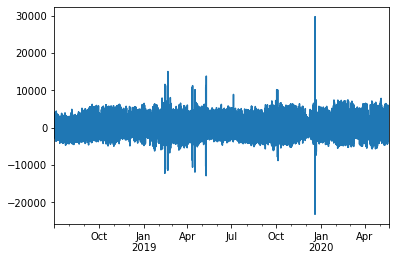

In [20]:
from gluonts.dataset.util import to_pandas
ax,fig = plt.subplots()
train_entry_df = to_pandas(train_entry)
print(train_entry_df.index)
train_entry_df.plot(ax=fig)

In [21]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_static_cat', 'source'])

In [22]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer

Failure when querying GPU: [15:21:30] include/mxnet/base.h:330: Check failed: e == cudaSuccess (35 vs. 0)  CUDA: CUDA driver version is insufficient for CUDA runtime version

Stack trace returned 10 entries:
[bt] (0) /home/adkulkar/.local/lib/python3.7/site-packages/mxnet/libmxnet.so(+0x4015ca) [0x7f2efe0465ca]
[bt] (1) /home/adkulkar/.local/lib/python3.7/site-packages/mxnet/libmxnet.so(+0x401be1) [0x7f2efe046be1]
[bt] (2) /home/adkulkar/.local/lib/python3.7/site-packages/mxnet/libmxnet.so(+0x2c2dd2d) [0x7f2f00872d2d]
[bt] (3) /home/adkulkar/.local/lib/python3.7/site-packages/mxnet/libmxnet.so(MXGetGPUCount+0x19) [0x7f2f00872dc9]
[bt] (4) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f2ff0de7630]
[bt] (5) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f2ff0de6fed]
[bt] (6) /opt/conda/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f2ff0dfd60e]
[bt] (7) /opt/conda/lib/python3.7/l

In [23]:
ctx = mx.cpu()

In [24]:
from gluonts.core.component import validated

class TimeFeature:
    """
    Base class for features that only depend on time.
    """

    @validated()
    def __init__(self, normalized: bool = True):
        self.normalized = normalized

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"
    
    
class HourOfDay(TimeFeature):
    """
    Hour of day encoded as value between [-0.5, 0.5]
    """

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        if self.normalized:
            return index.hour / 23.0 - 0.5
        else:
            return index.hour.map(float)


class DayOfWeek(TimeFeature):
    """
    Hour of day encoded as value between [-0.5, 0.5]
    """

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        if self.normalized:
            return index.dayofweek / 6.0 - 0.5
        else:
            return index.dayofweek.map(float)


class DayOfMonth(TimeFeature):
    """
    Day of month encoded as value between [-0.5, 0.5]
    """

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        if self.normalized:
            return index.day / 30.0 - 0.5
        else:
            return index.day.map(float)


class DayOfYear(TimeFeature):
    """
    Day of year encoded as value between [-0.5, 0.5]
    """

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        if self.normalized:
            return index.dayofyear / 364.0 - 0.5
        else:
            return index.dayofyear.map(float)

In [25]:
from pandas.tseries.frequencies import to_offset
from pandas.tseries import offsets

offset = to_offset(custom_ds_metadata['freq'])
features_by_offsets = {
    offsets.YearEnd: [],
    offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
    offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
    offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear]
}

In [26]:


for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            print([cls() for cls in feature_classes])

[__main__.HourOfDay(normalized=True), __main__.DayOfWeek(normalized=True), __main__.DayOfMonth(normalized=True), __main__.DayOfYear(normalized=True)]


In [27]:
ctx = mx.cpu()

In [37]:
dssm_estimator = DeepStateEstimator(
    freq = custom_ds_metadata['freq'],
    prediction_length=custom_ds_metadata['prediction_length'],
    cardinality=[3],
    add_trend=True,
    past_length=24,#train_size-custom_ds_metadata['prediction_length'],
    num_cells = 43,
    num_layers = 1,
    trainer=Trainer(ctx=ctx, 
                epochs=1, 
                learning_rate=4e-2, 
                hybridize=False, 
#                 num_batches_per_epoch=10
                batch_size= 1000
               )
)

In [38]:
# predictor = estimator.train(train_ds)
import time
tic = time.time()
predictor = dssm_estimator.train(train_ds)
print("Time taken is ",time.time()-tic)


100%|██████████| 50/50 [07:20<00:00,  8.80s/it, epoch=1/1, avg_epoch_loss=-.182] 

Time taken is  440.2393434047699


In [65]:
import os
os.mkdir("../saved_models/test/")

In [39]:
from pathlib import Path
predictor.serialize(Path("../saved_models/test/"))

In [88]:
ctx = mx.gpu()
ctx

gpu(0)

In [67]:
from gluonts.model.predictor import Predictor
with mx.Context(mx.cpu()):
    predictor = Predictor.deserialize(Path("../saved_models/test/"))

In [84]:
predictor.prediction_net

gluonts.model.deepstate._network.DeepStatePredictionNetwork(cardinality=[3], cell_type="lstm", dropout_rate=0.1, embedding_dimension=[2], innovation_bounds=gluonts.distribution.lds.ParameterBounds(lower=1e-06, upper=0.01), issm=gluonts.model.deepstate.issm.CompositeISSM(add_trend=True, seasonal_issms=[gluonts.model.deepstate.issm.SeasonalityISSM(num_seasons=24), gluonts.model.deepstate.issm.SeasonalityISSM(num_seasons=7)]), noise_std_bounds=gluonts.distribution.lds.ParameterBounds(lower=1e-06, upper=1.0), num_cells=43, num_layers=1, num_parallel_samples=100, past_length=24, prediction_length=24, prior_cov_bounds=gluonts.distribution.lds.ParameterBounds(lower=1e-06, upper=1.0), scaling=True)

In [29]:
from gluonts.evaluation.backtest import make_evaluation_predictions 

In [30]:
with mx.gpu(0):    test_ds = test_ds

In [75]:
make_evaluation_predictions?

In [68]:
with open("../saved_models/test/prediction_net-0000.params",'rb') as f:
    print(f.readline())

b'\x12\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0f\x00\x00\x00\x00\x00\x00\x00\xc9\xfa\x93\xf9\x00\x00\x00\x00\x02\x00\x00\x00!\x00\x00\x00\x00\x00\x00\x00+\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0e\xa8U\xbc\x03\x986\xbe"\xd0\x87>\xa1S\x06\xbc\xdf\x83\xd0=\x91S\n'


In [73]:
ds_sel = train_ds
ds_sel = val_ds
# ds_sel = test_ds
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds_sel,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [74]:
next(forecast_it)

MXNetError: Shape inconsistent, Provided = [172,7], inferred shape=(172,5)

In [70]:
forecasts = list(forecast_it)
tss = list(ts_it)

MXNetError: Shape inconsistent, Provided = [172,7], inferred shape=(172,5)

In [62]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(-1,)

IndexError: list index out of range

In [43]:
test_ds_entry = next(iter(ds_sel))

In [44]:
test_ds_entry['target'][:5],len(test_ds_entry['target'])

(array([ -62., 1802., 2916., 5386., 3106.], dtype=float32), 48)

In [45]:
forecast_entry = forecasts[0]

In [46]:
train_size //24

689

In [47]:
forecast_entry.start_date,forecast_entry.start_date - pd.Timestamp(custom_ds_metadata['start_train'][0])

(Timestamp('2020-05-21 22:00:00', freq='H'), Timedelta('690 days 14:00:00'))

In [48]:
pd.Timestamp(df.dt[train_size+val_size+test_size-1]) - pd.Timestamp(custom_ds_metadata['start_train'][0])

Timedelta('777 days 20:00:00')

In [49]:
len(pd.date_range(end = '2020-08-07 03:00:00', start = '2020-05-13 15:00:00').difference(df.index))

86

In [50]:
len(df)+853, (852*24+14)

(21542, 20462)

In [51]:
custom_ds_metadata['start_train'],custom_ds_metadata['start_val'],custom_ds_metadata['start_test']

([Timestamp('2018-07-01 08:00:00')],
 [Timestamp('2020-05-20 22:00:00')],
 [Timestamp('2020-08-15 02:00:00')])

In [52]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2020-05-21 22:00:00
Frequency of the time series: 1H


In [53]:
def plot_prob_forecasts(ts_entry, forecast_entry,title):
    plot_length = 24*2
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    

    fig, ax = plt.subplots(1, 1, figsize=(8, 5),dpi=150)
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
#     plt.plot(forecast_entry.mean)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.axvline(-24)
    plt.title(title)
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.ylabel('Ramp (MWh)')
    plt.xlabel('Time (H)')
#     plt.ylim([1800,3000])
#     plt.savefig('eia_dataset.png')
    plt.show()


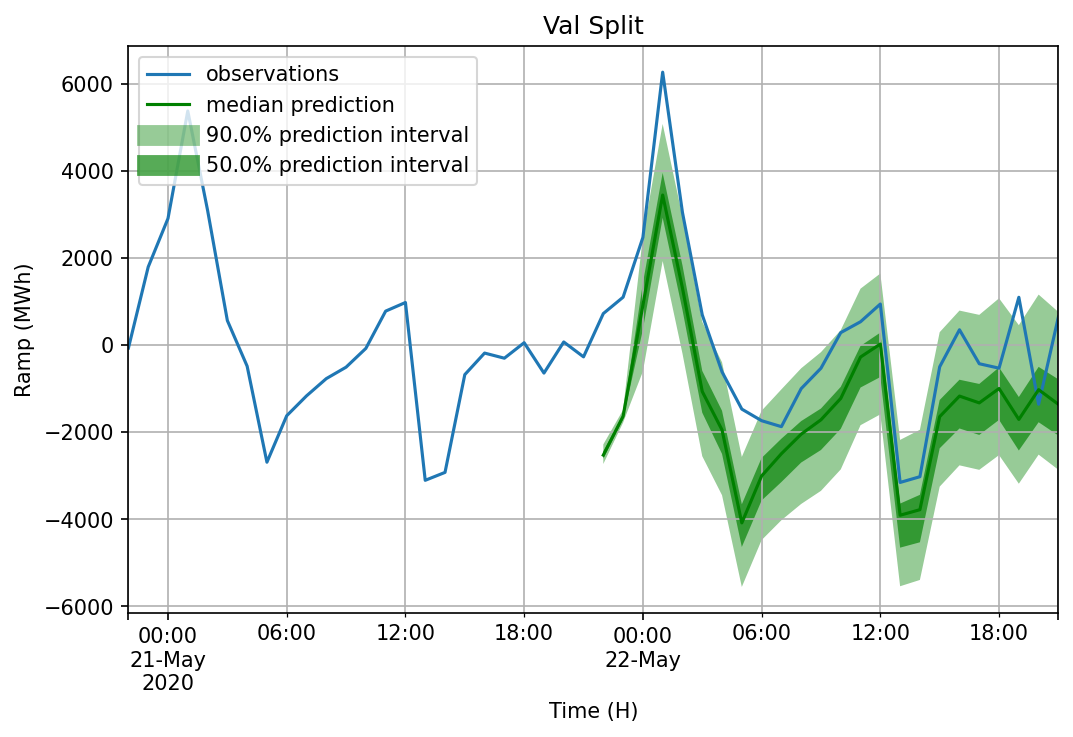

In [54]:
#Dummy test 1
plot_prob_forecasts(ts_entry, forecast_entry,'Val Split')

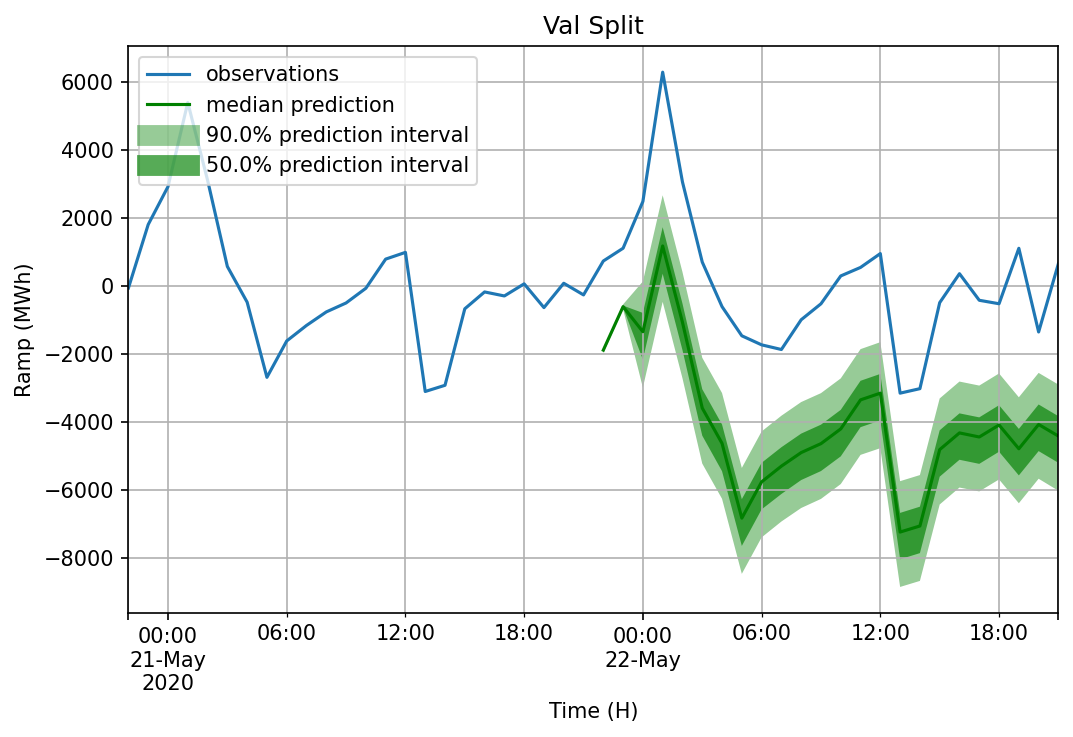

In [172]:
#After 4 layers Training 20 Epochs 4e-3
# plot_prob_forecasts(ts_entry, forecast_entry,'Val Split')

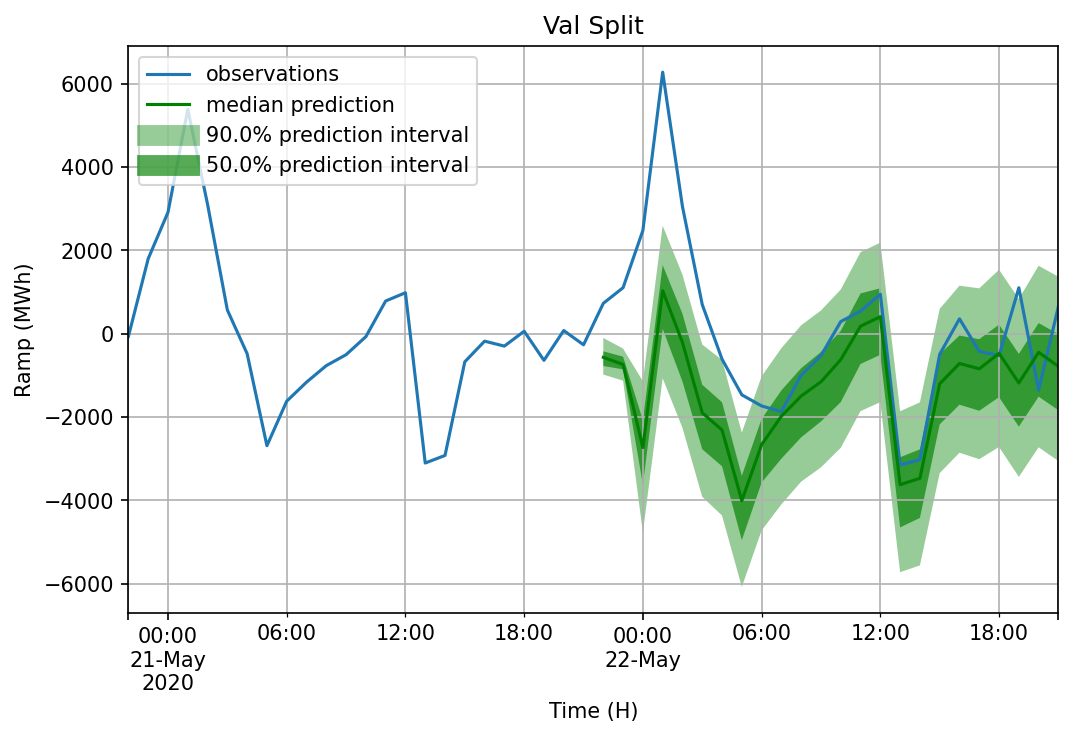

In [192]:
#After 4 layers Training 1 Epochs
# plot_prob_forecasts(ts_entry, forecast_entry,'Val Split')

In [173]:
from gluonts.evaluation import Evaluator

In [174]:
#After Training 20 Epochs, 4 layers
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(val_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 1/1 [00:07<00:00,  7.72s/it]


{
    "MSE": 17547792.0,
    "abs_error": 97342.609375,
    "abs_target_sum": 34407.0,
    "abs_target_mean": 1433.625,
    "seasonal_error": 1149.0434782608695,
    "MASE": 3.52984211131029,
    "MAPE": 5.155786764129064,
    "sMAPE": 1.6067861200573852,
    "OWA": NaN,
    "MSIS": 89.05771577493567,
    "QuantileLoss[0.1]": 24569.482373046878,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 97342.60766601562,
    "Coverage[0.5]": 0.0,
    "QuantileLoss[0.9]": 126768.005859375,
    "Coverage[0.9]": 0.0,
    "RMSE": 4189.008474567699,
    "NRMSE": 2.9219694652141937,
    "ND": 2.82915131731915,
    "wQuantileLoss[0.1]": 0.7140838309950556,
    "wQuantileLoss[0.5]": 2.829151267649479,
    "wQuantileLoss[0.9]": 3.684366723613654,
    "mean_wQuantileLoss": 2.4092006074193963,
    "MAE_Coverage": 0.5
}


In [193]:
#After Training 1 Epochs, 4 layers
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(val_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


{
    "MSE": 4505396.333333333,
    "abs_error": 35469.62109375,
    "abs_target_sum": 34407.0,
    "abs_target_mean": 1433.625,
    "seasonal_error": 1149.0434782608695,
    "MASE": 1.2862010070699164,
    "MAPE": 1.3775076443862366,
    "sMAPE": 1.159993850540498,
    "OWA": NaN,
    "MSIS": 21.007355282907017,
    "QuantileLoss[0.1]": 14791.290625000001,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 35469.6208190918,
    "Coverage[0.5]": 0.08333333333333333,
    "QuantileLoss[0.9]": 31228.381713867188,
    "Coverage[0.9]": 0.625,
    "RMSE": 2122.591890433329,
    "NRMSE": 1.4805767829337022,
    "ND": 1.0308838635670068,
    "wQuantileLoss[0.1]": 0.42989190063068566,
    "wQuantileLoss[0.5]": 1.030883855584381,
    "wQuantileLoss[0.9]": 0.9076171044806925,
    "mean_wQuantileLoss": 0.7894642868985864,
    "MAE_Coverage": 0.2638888888888889
}


In [194]:
def log_eval(configs, agg_metrics):
    if not os.path.exists('logs'):
        os.makedirs('logs')
    filename = datetime.datetime.now().isoformat(timespec='seconds') + '.json'
    log_content = {
        'configuration': vars(configs),
        'results': agg_metrics
        }
    with open(os.path.join('logs', filename), 'w') as f:
        json.dump(log_content, f)

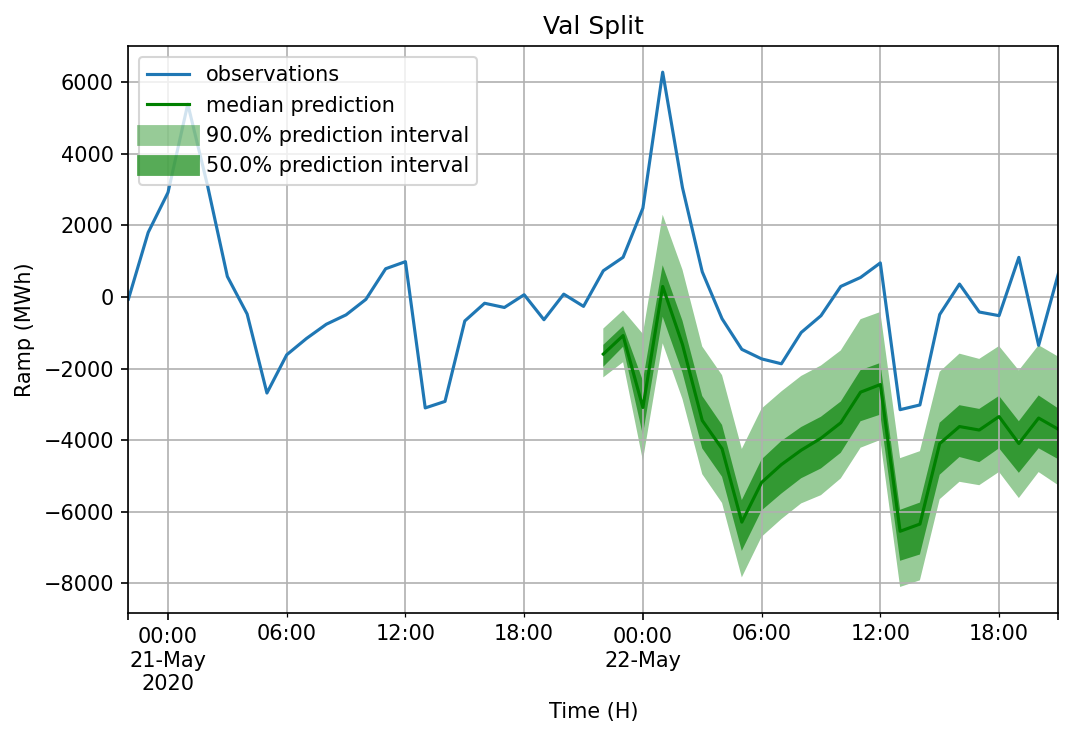

Running evaluation: 100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


{
    "MSE": 14362566.666666666,
    "abs_error": 88457.8203125,
    "abs_target_sum": 34407.0,
    "abs_target_mean": 1433.625,
    "seasonal_error": 1149.0434782608695,
    "MASE": 3.2076614877962455,
    "MAPE": 4.475809715007588,
    "sMAPE": 1.5870409860669799,
    "OWA": NaN,
    "MSIS": 40.624115521416684,
    "QuantileLoss[0.1]": 23349.384179687502,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 88457.8134765625,
    "Coverage[0.5]": 0.0,
    "QuantileLoss[0.9]": 94652.62448730468,
    "Coverage[0.9]": 0.0,
    "RMSE": 3789.7977078818685,
    "NRMSE": 2.643506989541804,
    "ND": 2.570925111532537,
    "wQuantileLoss[0.1]": 0.6786230761091494,
    "wQuantileLoss[0.5]": 2.5709249128538523,
    "wQuantileLoss[0.9]": 2.7509699912025076,
    "mean_wQuantileLoss": 2.00017266005517,
    "MAE_Coverage": 0.5
}


In [215]:
#After 1 layers Training 1 Epochs
plot_prob_forecasts(ts_entry, forecast_entry,'Val Split')
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(val_ds))
print(json.dumps(agg_metrics, indent=4))

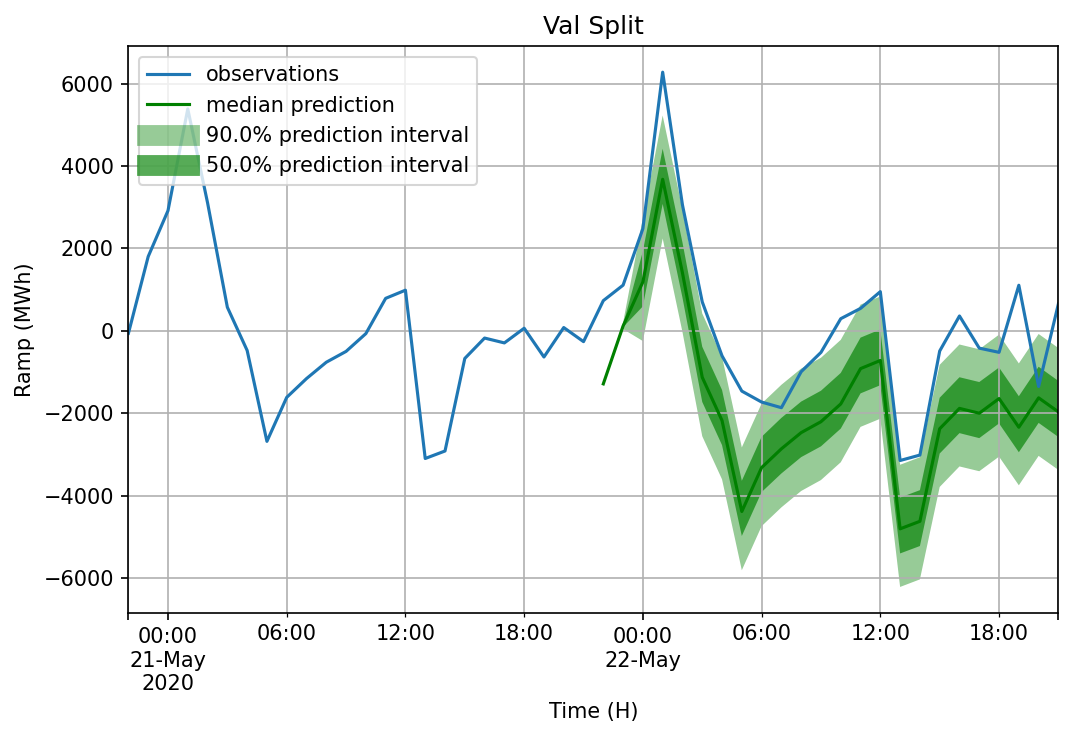

Running evaluation: 100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


{
    "MSE": 3405526.6666666665,
    "abs_error": 42282.9609375,
    "abs_target_sum": 34407.0,
    "abs_target_mean": 1433.625,
    "seasonal_error": 1149.0434782608695,
    "MASE": 1.5332666451656387,
    "MAPE": 2.264481441742526,
    "sMAPE": 1.2302394932522243,
    "OWA": NaN,
    "MSIS": 14.251454078455302,
    "QuantileLoss[0.1]": 13196.159716796876,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 42282.95977783203,
    "Coverage[0.5]": 0.0,
    "QuantileLoss[0.9]": 29702.29916381836,
    "Coverage[0.9]": 0.125,
    "RMSE": 1845.406910864557,
    "NRMSE": 1.287231257033434,
    "ND": 1.228905773171157,
    "wQuantileLoss[0.1]": 0.3835312499432347,
    "wQuantileLoss[0.5]": 1.2289057394667373,
    "wQuantileLoss[0.9]": 0.8632632651442543,
    "mean_wQuantileLoss": 0.8252334181847422,
    "MAE_Coverage": 0.4583333333333333
}


In [234]:
#After 1 layers Training 20 Epochs
plot_prob_forecasts(ts_entry, forecast_entry,'Val Split')
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(val_ds))
print(json.dumps(agg_metrics, indent=4))

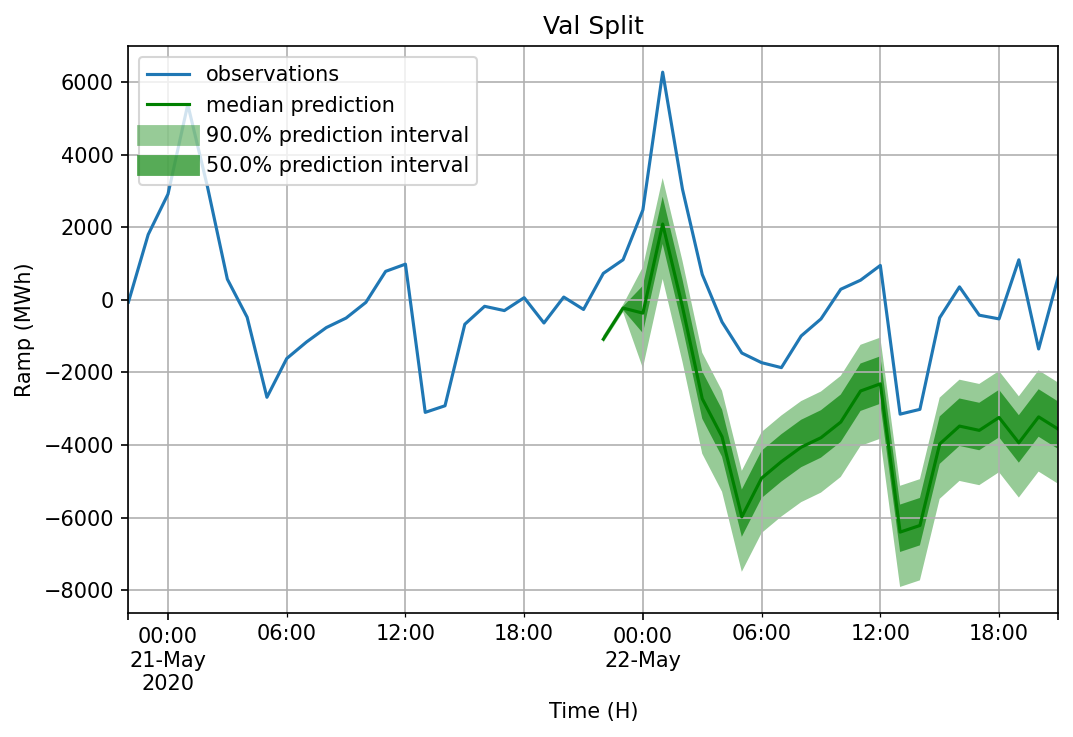

Running evaluation: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


{
    "MSE": 11138532.0,
    "abs_error": 77433.140625,
    "abs_target_sum": 34407.0,
    "abs_target_mean": 1433.625,
    "seasonal_error": 1149.0434782608695,
    "MASE": 2.80788405348967,
    "MAPE": 4.116947398312994,
    "sMAPE": 1.539051401226427,
    "OWA": NaN,
    "MSIS": 62.41574178743505,
    "QuantileLoss[0.1]": 21272.013037109376,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 77433.14306640625,
    "Coverage[0.5]": 0.0,
    "QuantileLoss[0.9]": 95759.11450195314,
    "Coverage[0.9]": 0.0,
    "RMSE": 3337.4439321133173,
    "NRMSE": 2.327975539010074,
    "ND": 2.250505438573546,
    "wQuantileLoss[0.1]": 0.6182466660013769,
    "wQuantileLoss[0.5]": 2.2505055095302193,
    "wQuantileLoss[0.9]": 2.783128854650308,
    "mean_wQuantileLoss": 1.8839603433939682,
    "MAE_Coverage": 0.5
}


In [248]:
#After 1 layers Training 30 Epochs and learning rate 4e-2
plot_prob_forecasts(ts_entry, forecast_entry,'Val Split')
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(val_ds))
print(json.dumps(agg_metrics, indent=4))